In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Models

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt


In [3]:
"""
Download MNIST dataset
"""

# Define a transform to normalize the data.
# I removed .Normalize since we want to explore adversarial training it's ok to have a sub-optimal model.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor [0,1]
    #transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

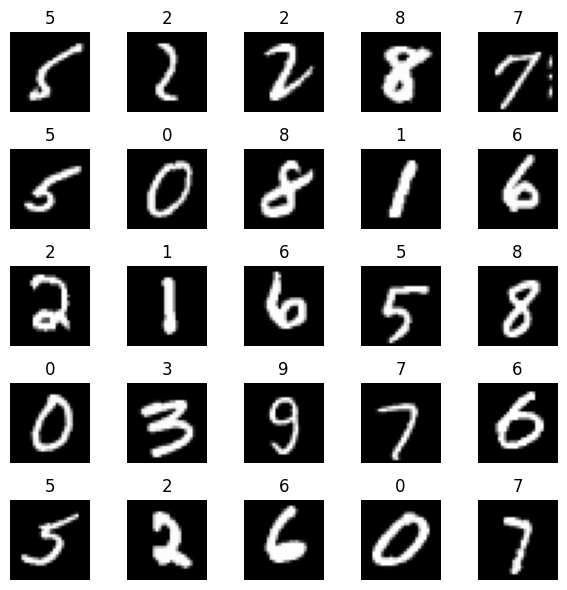

torch.Size([64, 1, 28, 28])
tensor([5, 2, 2, 8, 7, 5, 0, 8, 1, 6])


In [4]:
"""
Visualize dataset
"""

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the first 25 images in a 5x5 grid
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze removes the channel dim
    plt.title(f"{labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(images.shape)  # torch.Size([64, 1, 28, 28])
print(labels[:10])   # tensor of labels

In [5]:
"""
Define a model
"""

device = torch.device("mps")
model = Models.SmallConvNet().to(device)  # device = torch.device("cuda" or "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [6]:
"""
Train the basic model (no adversarial training)
"""

Models.train(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5)

Epoch 1/5 | Train Loss: 0.3751, Train Acc: 88.65% | Test Loss: 0.1094, Test Acc: 96.73%
Epoch 2/5 | Train Loss: 0.1046, Train Acc: 96.77% | Test Loss: 0.0793, Test Acc: 97.48%
Epoch 3/5 | Train Loss: 0.0759, Train Acc: 97.63% | Test Loss: 0.0681, Test Acc: 97.68%
Epoch 4/5 | Train Loss: 0.0606, Train Acc: 98.11% | Test Loss: 0.0477, Test Acc: 98.39%
Epoch 5/5 | Train Loss: 0.0510, Train Acc: 98.39% | Test Loss: 0.0464, Test Acc: 98.45%


In [7]:
"""
Useful function to see model output
"""

def plot_predictions(model, images, gt_labels, device, n_max):
    model.eval()
    n_images = images.shape[0]
    assert n_images == gt_labels.shape[0]
    images, gt_labels = images.to(device), gt_labels.to(device)

    # Run model
    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

    # Plot the first n examples
    n = min(n_images, n_max)
    for i in range(n):
        plt.figure(figsize=(10, 3))

        # Plot the image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze().cpu(), cmap='gray')
        plt.title(f"True: {gt_labels[i].item()}")
        plt.axis('off')

        probs_list = list(probs[i])
        probs_list = [round(p.item(), 10) for p in probs[i]]

        """
        # Plot the probabilities
        plt.subplot(1, 2, 2)
        plt.bar(range(10), probs[i].cpu().numpy())
        plt.xticks(range(10))
        plt.title(f"Predicted: {probs[i].argmax().item()}")
        plt.xlabel("Digit")
        plt.ylabel("Probability")"
        """

        plt.tight_layout()
        plt.show()
        print("Output probabilities: ", probs_list)

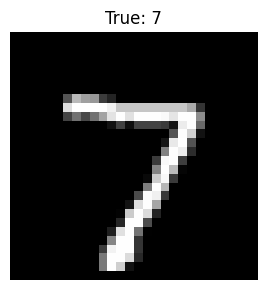

Output probabilities:  [5.1e-09, 1.15e-07, 1.9341e-06, 6.4372e-06, 1.41e-08, 2.378e-07, 0.0, 0.9999899864, 1.882e-07, 1.0482e-06]


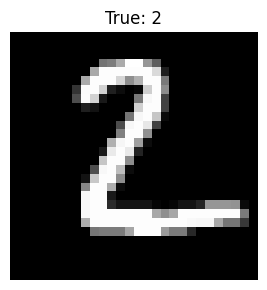

Output probabilities:  [1e-09, 0.0003746966, 0.999625206, 8.7e-09, 0.0, 0.0, 1e-10, 1.02e-08, 2.1e-09, 0.0]


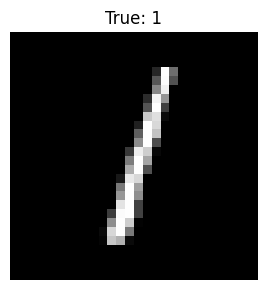

Output probabilities:  [1.1444e-06, 0.9996480942, 1.77557e-05, 1.393e-06, 6.33568e-05, 3.4112e-06, 1.74024e-05, 7.35725e-05, 0.000170793, 3.0303e-06]


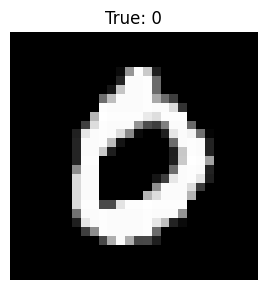

Output probabilities:  [0.9988425374, 2e-10, 9.23e-08, 3.6e-09, 0.0, 2.7733e-06, 0.0011539963, 5.74e-08, 2.38e-08, 5.925e-07]


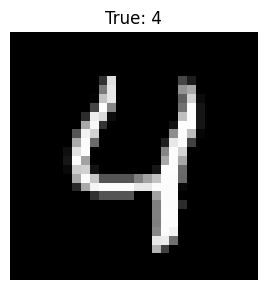

Output probabilities:  [1.089e-07, 2.664e-07, 1.57e-08, 7.25e-08, 0.9957236052, 9.949e-07, 1.431e-07, 2.7235e-05, 7.93e-08, 0.0042474684]


In [8]:
images, labels = next(iter(test_loader))
plot_predictions(model, images, labels, device, 5)

Fun note / something to explore: shape of perturbations change according to model size (discovered with epsilon = 0.3)

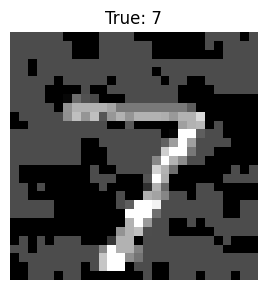

Output probabilities:  [1.5742e-06, 8.97264e-05, 0.0002067539, 0.9953906536, 2.04e-08, 0.0025275245, 1.091e-07, 4.5831e-06, 0.0001806998, 0.0015983003]


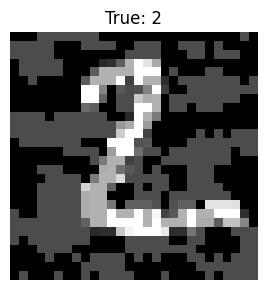

Output probabilities:  [5.306e-07, 0.9959226847, 0.0037920906, 1.93755e-05, 4.134e-07, 0.0002442733, 1.15452e-05, 3.769e-07, 8.2835e-06, 3.641e-07]


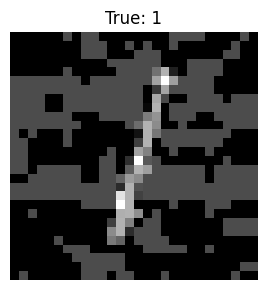

Output probabilities:  [0.000436285, 0.0625926405, 0.8859922886, 0.027162319, 0.000606195, 0.0002845248, 0.0001089423, 0.007092814, 0.0154720135, 0.000251971]


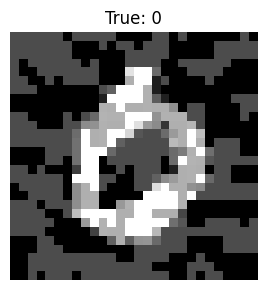

Output probabilities:  [0.0146927815, 5.37511e-05, 3.0612e-06, 5.644e-07, 1.218e-07, 0.0002781575, 0.9849672914, 1.68e-08, 1.8901e-06, 2.3705e-06]


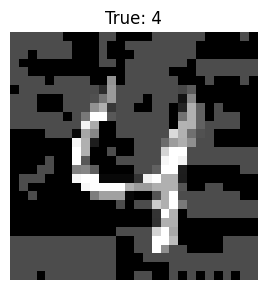

Output probabilities:  [1.426e-07, 5.127e-07, 1.136e-07, 1.88287e-05, 6.1786e-05, 0.0004460032, 2.722e-07, 3.2647e-06, 1.5577e-06, 0.9994676709]


In [9]:
"""
Notice how much the model is fooled by the perturbations with extreme confidence.
Not that we use a much higher epsilon (perturbation value) of 0.3 than in the typical imagenet example (usually around 0.01)
since MNIST has much smaller dimensions, number of classes and all around complexity !
"""

images, labels = next(iter(test_loader))

for i in range(5):
    image = images[i].unsqueeze(0)  # Add batch dimension back → shape (1, 1, 28, 28)
    label = labels[i].unsqueeze(0)
    adv_image, perturbation = Models.fgsm_attack_untargeted(image, label, model, nn.CrossEntropyLoss(), 0.3, device)
    plot_predictions(model, adv_image, label, device, 1)

In [10]:
"""
robustModel is trained on adversarial examples.
Higher accuracy on test set since train set has adversarial examples.
"""

robustModel = Models.SmallConvNet().to(device)
optimizer = torch.optim.Adam(robustModel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
Models.train_adversarial(robustModel, train_loader, test_loader, optimizer, criterion, device, num_epochs=5, max_adversarial_prob=3/4)

Epoch 1/5 | Train Loss: 0.6357, Train Acc: 80.07% | Test Loss: 0.1405, Test Acc: 96.37%
Epoch 2/5 | Train Loss: 0.4240, Train Acc: 86.02% | Test Loss: 0.1200, Test Acc: 96.24%
Epoch 3/5 | Train Loss: 0.3723, Train Acc: 87.83% | Test Loss: 0.0884, Test Acc: 97.32%
Epoch 4/5 | Train Loss: 0.3518, Train Acc: 88.92% | Test Loss: 0.0876, Test Acc: 97.31%
Epoch 5/5 | Train Loss: 0.2554, Train Acc: 92.23% | Test Loss: 0.1033, Test Acc: 96.49%


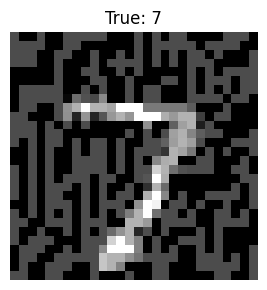

Output probabilities:  [0.0001763606, 0.0068013095, 0.0053371517, 0.0116031244, 0.0002044513, 0.0195916202, 1.54e-08, 0.953450799, 0.002799192, 3.60422e-05]


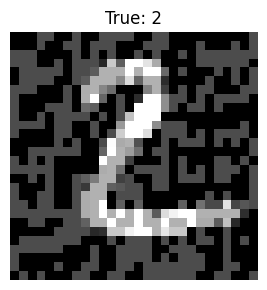

Output probabilities:  [0.0268035382, 0.0017095034, 0.2989545763, 0.0173253454, 8.57902e-05, 0.6367775202, 0.0143855931, 1.0653e-06, 0.0039557652, 1.3036e-06]


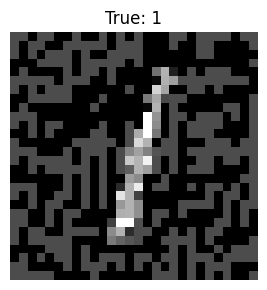

Output probabilities:  [4.25454e-05, 0.9954243302, 0.002194328, 0.0001624236, 0.0004825682, 0.0004325245, 4.4524e-06, 0.0008341937, 0.0004220899, 5.027e-07]


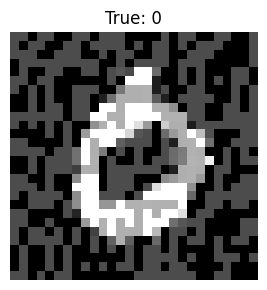

Output probabilities:  [0.9680739641, 5.559e-07, 0.0009036677, 0.0001818304, 5.34488e-05, 0.0198820625, 0.0090162288, 1.17085e-05, 0.0018737846, 2.7983e-06]


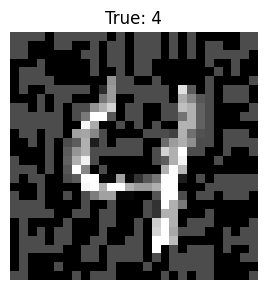

Output probabilities:  [0.000151463, 2.122e-07, 4.1015e-06, 2.03274e-05, 0.9946474433, 4.0071e-06, 0.0002343241, 0.0002879195, 2.09765e-05, 0.0046292208]


In [18]:
"""
Unlike the basic model, the robustModel is rarely fooled by adversarial examples, and never with high confidence.
"""

images, labels = next(iter(test_loader))

for i in range(5):
    image = images[i].unsqueeze(0)  # Add batch dimension back → shape (1, 1, 28, 28)
    label = labels[i].unsqueeze(0)
    adv_image, perturbation = Models.fgsm_attack_untargeted(image, label, robustModel, nn.CrossEntropyLoss(), 0.3, device)
    plot_predictions(robustModel, adv_image, label, device, 1)

In [12]:
"""
Plot the evolution of the model predictions from one image to another.
"""

def interpolate_linear(tensor1, tensor2, alpha):
    assert 0 <= alpha <= 1
    return alpha * tensor2 + (1 - alpha) * tensor1

def plot_model_pred_interpolation(model, im1, im2, steps, device):
    model.eval()
    preds = []

    for step in range(steps):
        alpha = step / (steps - 1)
        im = interpolate_linear(im1, im2, alpha).to(device)

        with torch.no_grad():
            output = model(im)
            probs = F.softmax(output, dim=1)[0].tolist()  # Get probabilities for the single image
            preds.append(probs)

    preds = torch.tensor(preds)  # Shape: [steps, 10]

    # Plot
    plt.figure(figsize=(10, 6))
    for digit in range(10):
        plt.plot(range(steps), preds[:, digit], label=f"{digit}")
    plt.xlabel("Interpolation step")
    plt.ylabel("Predicted probability")
    plt.title("Model output probabilities along linear interpolation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Basic model


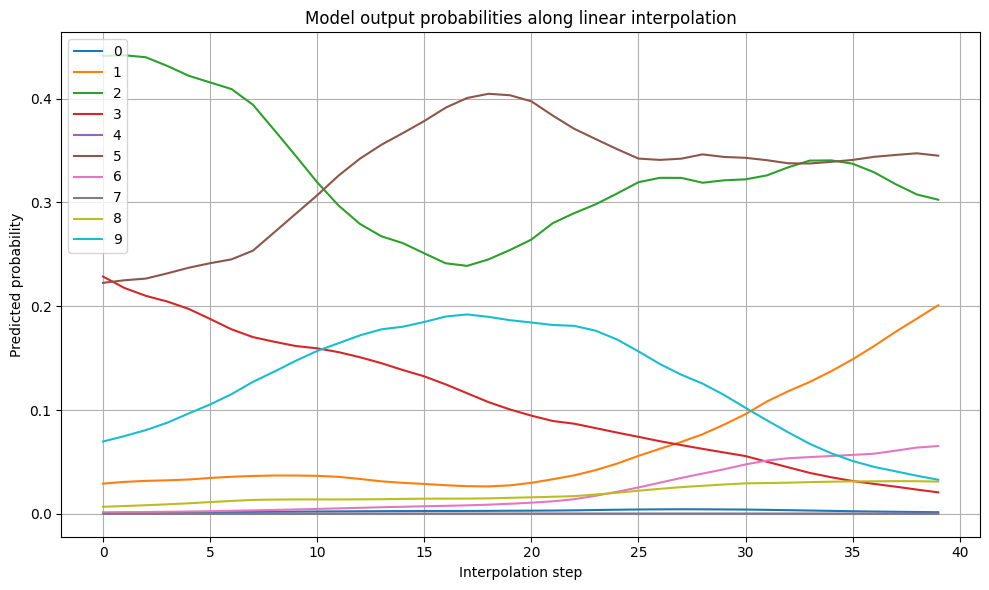

Robust model


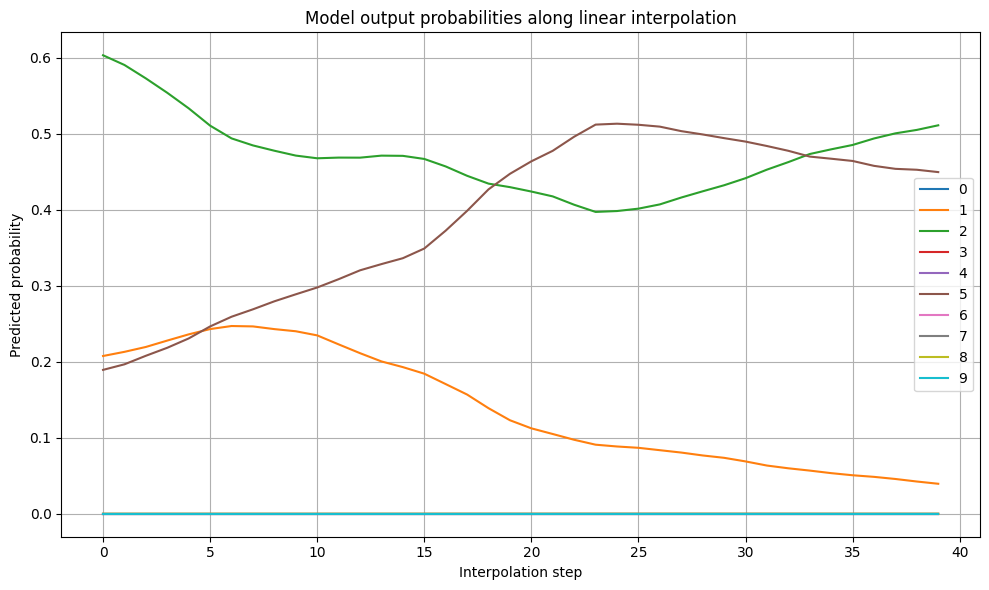

In [13]:
"""
The robust model is much smoother
"""

#im1, im2 = images[-1].unsqueeze(0).to(device), images[-2].unsqueeze(0).to(device)
im1, im2 = torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 1, 28, 28)).to(device)

print("Basic model")
plot_model_pred_interpolation(model, im1, im2, 40, device)
print("Robust model")
plot_model_pred_interpolation(robustModel, im1, im2, 40, device)

In [14]:
import numpy as np

"""
Extend above to 2d
Define a 2d plane where the point at coordinates x, y is A + xB + yC (more or less).
Visualize the "smoothness" of the model's prediction for given class (class_idx)
"""

def plot_prediction_plane(model, A, B, C, class_idx, device, grid_size=21, span=1.0):
    """
    Visualize model confidence for a given class over a 2D plane in image space.

    Args:
        model: the trained model
        A: reference image tensor, shape (1, 1, 28, 28)
        B: direction vector image, same shape
        C: direction vector image, same shape
        class_idx: index of the class to visualize (e.g. 4)
        device: torch device
        grid_size: resolution of the 2D grid (e.g. 21 x 21)
        span: how far to go in each direction (range will be [-span, +span])
    """
    model.eval()
    A, B, C = A.to(device), B.to(device), C.to(device)
    
    x_vals = np.linspace(-span, span, grid_size)
    y_vals = np.linspace(-span, span, grid_size)

    heatmap = np.zeros((grid_size, grid_size))

    with torch.no_grad():
        for i, x in enumerate(x_vals):
            for j, y in enumerate(y_vals):
                img = A + x * B + y * C
                img = torch.clamp(img, 0, 1).to(device)
                output = model(img)
                prob = F.softmax(output, dim=1)[0, class_idx].item()
                heatmap[j, i] = prob  # note: row = y (j), column = x (i)

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(heatmap, extent=(-span, span, -span, span), origin='lower', cmap='viridis')
    plt.colorbar(label=f"Probability of class {class_idx}")
    plt.title(f"Model confidence for class {class_idx} over 2D plane")
    plt.xlabel("x (direction B)")
    plt.ylabel("y (direction C)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [15]:
"""
Same as above but visualize 3 output probabilities thanks to RGB
"""

def plot_prediction_plane_rgb(model, A, B, C, class_indices, device, grid_size=21, span=1.0):
    """
    Visualize model confidence for 3 classes using RGB over a 2D plane in image space.

    Args:
        model: the trained model
        A: reference image tensor, shape (1, 1, 28, 28)
        B: direction vector image, same shape
        C: direction vector image, same shape
        class_indices: list of 3 class indices to map to R, G, B
        device: torch device
        grid_size: resolution of the 2D grid (e.g. 21 x 21)
        span: range of values for x and y in both directions
    """
    assert len(class_indices) == 3, "Must provide exactly 3 class indices"
    model.eval()
    A, B, C = A.to(device), B.to(device), C.to(device)
    
    x_vals = np.linspace(-span, span, grid_size)
    y_vals = np.linspace(-span, span, grid_size)

    heatmap = np.zeros((grid_size, grid_size, 3))  # RGB image

    with torch.no_grad():
        for i, x in enumerate(x_vals):
            for j, y in enumerate(y_vals):
                img = A + x * B + y * C
                img = torch.clamp(img, 0, 1).to(device)

                output = model(img)
                output = output/3 # Attempt temperature scaling to get less black
                probs = F.softmax(output, dim=1)[0]
                r, g, b = [probs[class_idx].item() for class_idx in class_indices]
                rgb = np.array([r, g, b])
                if rgb.sum() > 0:
                    rgb = rgb / rgb.sum()  # normalize to keep color proportions but max brightness
                heatmap[j, i] = rgb

                heatmap[j, i, 0] = r  # Red channel
                heatmap[j, i, 1] = g  # Green channel
                heatmap[j, i, 2] = b  # Blue channel

    # Normalize heatmap values (optional but helps if probs < 1.0)
    heatmap = np.clip(heatmap, 0, 1)

    # Plot RGB heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, extent=(-span, span, -span, span), origin='lower')
    plt.title(f"Model prediction blend (R={class_indices[0]}, G={class_indices[1]}, B={class_indices[2]})")
    plt.xlabel("x (direction B)")
    plt.ylabel("y (direction C)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

Basic model


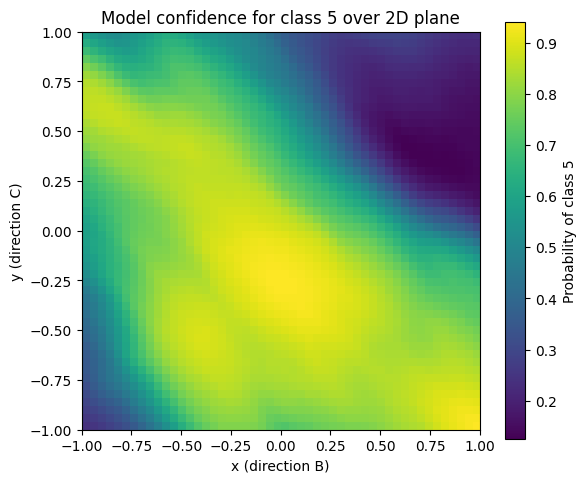

Robust model


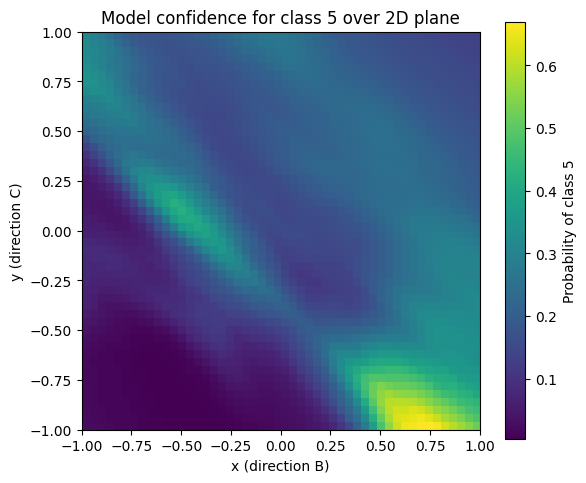

In [16]:
#im1, im2 = images[-1].unsqueeze(0).to(device), images[-2].unsqueeze(0).to(device)
im1, im2, im3 = torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 1, 28, 28)).to(device)

"""
# im1: constant base image filled with 0.5 → center of pixel range
im1 = torch.full((1, 1, 28, 28), 0.5).to(device)

# im2 & im3: random directions with values in {-0.5, 0.5}
im2 = 0.5 * (2 * torch.randint(0, 2, (1, 1, 28, 28)) - 1).float().to(device)
im3 = 0.5 * (2 * torch.randint(0, 2, (1, 1, 28, 28)) - 1).float().to(device)"
"""

print("Basic model")
plot_prediction_plane(model, im1, im2, im3, 5, device, grid_size=50, span=1.0)
print("Robust model")
plot_prediction_plane(robustModel, im1, im2, im3, 5, device, grid_size=50, span=1.0)

Basic model


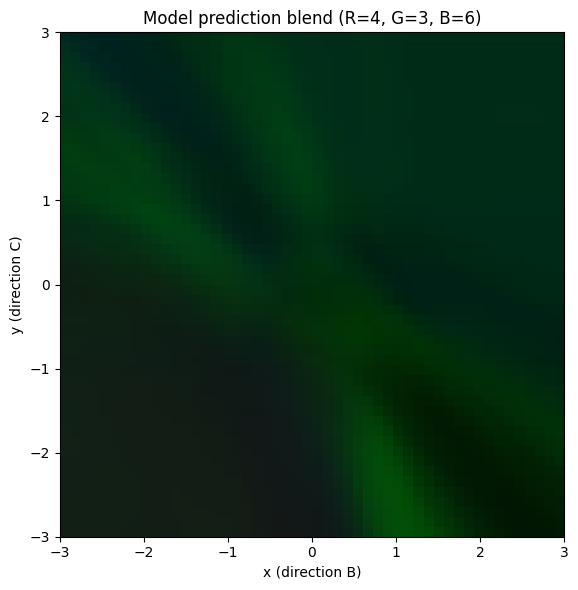

Robust model


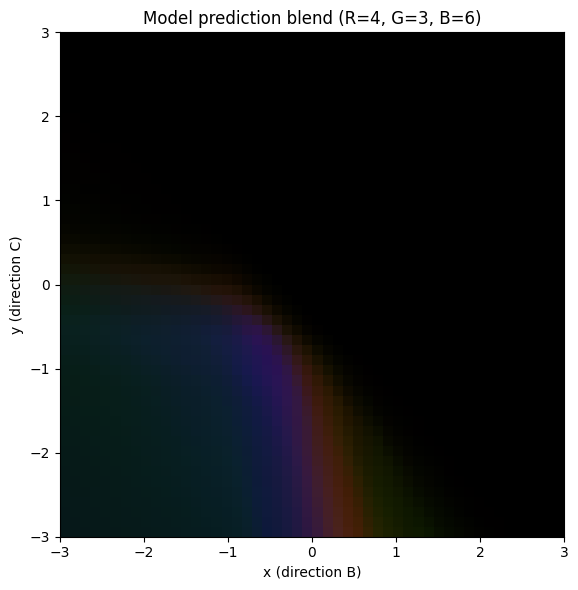

In [17]:
#im1, im2 = images[-1].unsqueeze(0).to(device), images[-2].unsqueeze(0).to(device)
#im1, im2, im3 = torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 1, 28, 28)).to(device), torch.rand((1, 1, 28, 28)).to(device)

print("Basic model")
plot_prediction_plane_rgb(model, im1, im2, im3, [4, 3, 6], device, grid_size=50, span=3.0)
print("Robust model")
plot_prediction_plane_rgb(robustModel, im1, im2, im3, [4, 3, 6], device, grid_size=50, span=3.0)